# MultiViewAtlas - Atlas building demo (PBMCs)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os,sys
import mudata
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

import scvi

import multi_view_atlas as mva

## Load PBMC dataset

In [10]:
h5ad_file = '/home/jupyter/mount/gdrive/diff2atlas/figshare_data/PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad'
adata_full = sc.read_h5ad(h5ad_file)

In [11]:
## Subsample for demo purposes
sc.pp.subsample(adata_full, fraction = 0.1)

In [12]:
## Take out Stephenson to use as query
dID = '10_1038_s41591_021_01329_2'
adata_query = adata_full[adata_full.obs['dataset_id'] == dID].copy()
adata_full = adata_full[adata_full.obs['dataset_id'] != dID].copy()

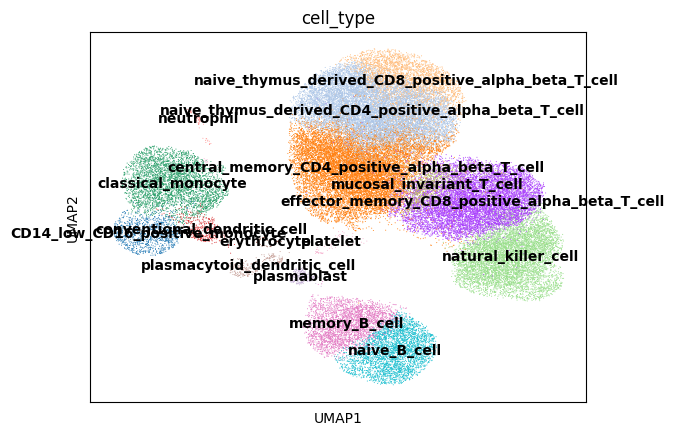

In [24]:
sc.pl.umap(adata_full, color='cell_type', legend_loc='on data')

## Initialize MultiViewAtlas object

In this case we initialize simply splitting lymphoid from rest based on annotation

In [25]:
assign_dict = {
    'Ery_myeloid':['classical_monocyte',
     'CD14_low_CD16_positive_monocyte',
     'plasmacytoid_dendritic_cell',
     'conventional_dendritic_cell',
     'neutrophil',
     'erythrocyte',
     'plasmablast',
     'platelet'],
    'Lymphoid' : ['effector_memory_CD8_positive_alpha_beta_T_cell',
    'central_memory_CD4_positive_alpha_beta_T_cell',
     'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
     'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
     'naive_B_cell',
     'mucosal_invariant_T_cell',
     'natural_killer_cell',
     'memory_B_cell']
    }

transition_rule = 'cell_type'

# make table assigning cells to views (store in .obsm)
assign_tab = np.vstack([np.where(adata_full.obs[transition_rule].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = adata_full.obs_names)
adata_full.obsm['view_assign'] = assign_tab.copy()

## Make view hierarchy (store in .uns)
view_hierarchy = {
    'Ery_myeloid': None,
    'Lymphoid': None    
}

adata_full.uns['view_hierarchy'] = view_hierarchy.copy()

## Make MultiViewAtlas object
mvatlas = mva.tl.MultiViewAtlas(adata_full, transition_rule='cell_type') 

In [26]:
mvatlas.mdata

MuData object with n_obs × n_vars = 58340 × 11724
  obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
  obsm:	'view_assign'
  3 modalities
    full:	58340 x 11724
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
      var:	'gene_id', 'gene_name'
      uns:	'cell_type_colors', 'view_hierarchy'
      obsm:	'X_scVI', 'X_umap', '_scvi_extra_categoricals', 'view_assign'
    Ery_myeloid:	5659 x 0
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
    Lymphoid:	52681 x 0
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'

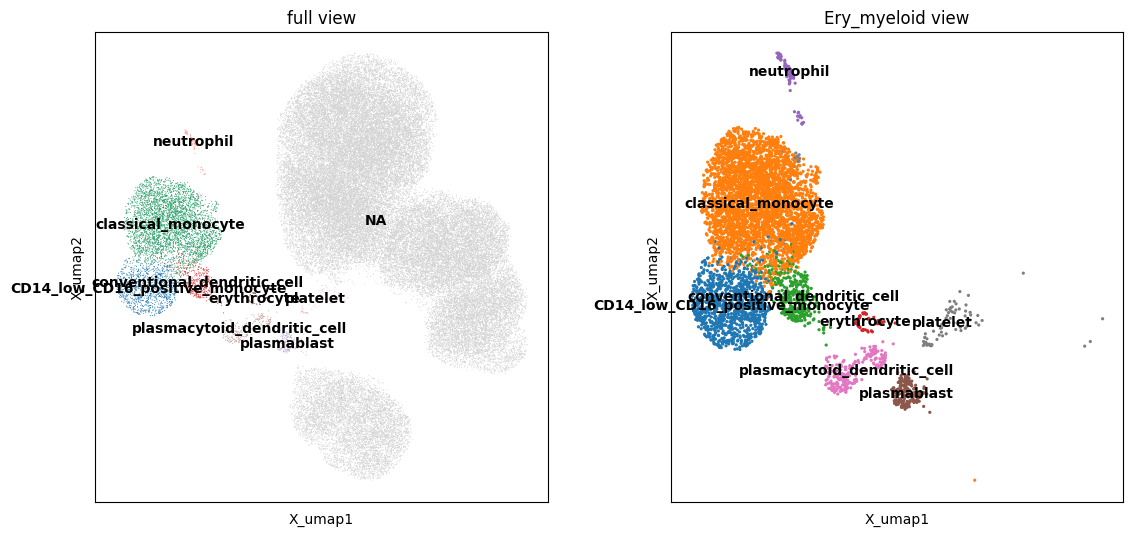

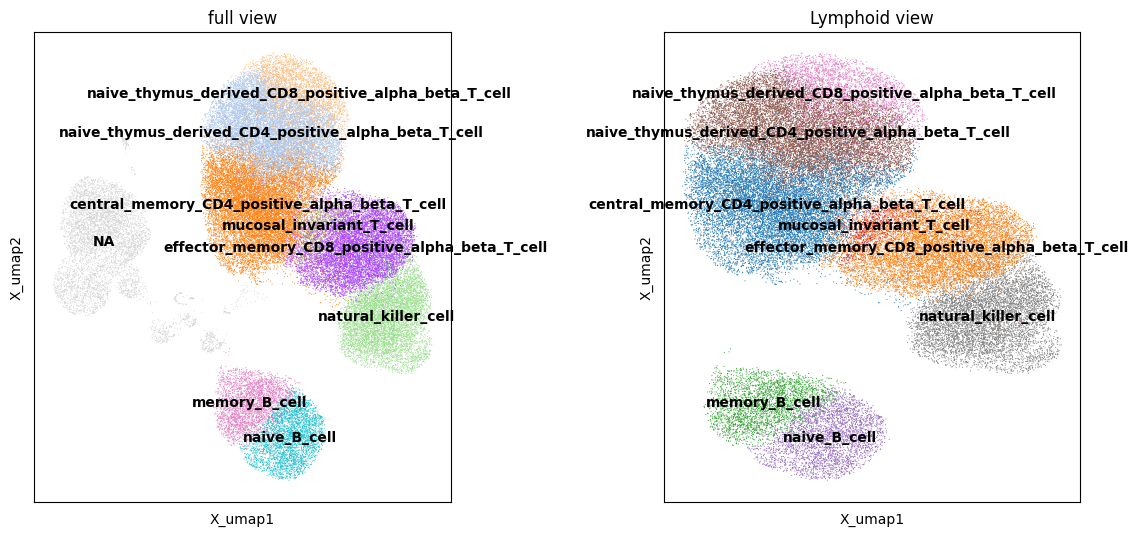

In [11]:
mva.pl.multiview_embedding(mvatlas.mdata, view='Ery_myeloid', color='cell_type', basis_from_full=True)
mva.pl.multiview_embedding(mvatlas.mdata, view='Lymphoid', color='cell_type', basis_from_full=True)

In [27]:
mvatlas.view_transition_rule

full Ery_myeloid   Lymphoid
full               NaN   cell_type  cell_type
Ery_myeloid  cell_type         NaN        NaN
Lymphoid     cell_type         NaN        NaN

## Compute scVI embedding for subsets 

In [30]:
mva.tl.train_scvi_multiview(mvatlas, save_path='./data' )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [04:16<00:00,  5.06s/it, loss=1.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=1.58e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:25<00:00,  1.98it/s, loss=2.24e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s, loss=2.24e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [03:51<00:00,  4.66s/it, loss=1.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [03:51<00:00,  4.63s/it, loss=1.54e+03, v_num=1]


Each view stores the path to the saved trained model in `.uns[model_dir]` (this will be used for mapping with scArches)

In [31]:
mva.tl.knn_umap_multiview(mvatlas)

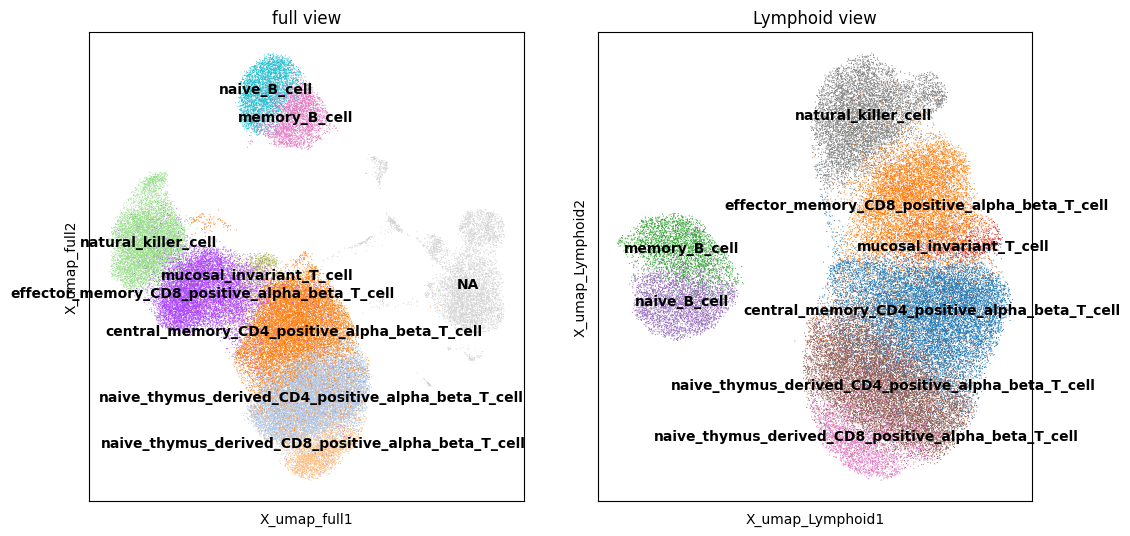

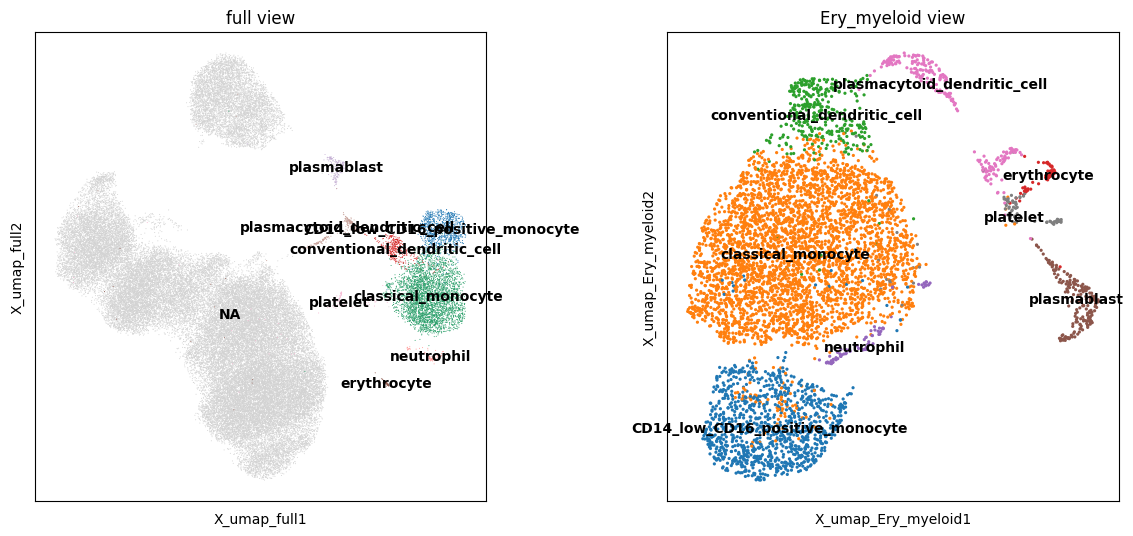

In [32]:
mva.pl.multiview_embedding(mvatlas, view='Lymphoid', color='cell_type', basis='X_umap')
mva.pl.multiview_embedding(mvatlas, view='Ery_myeloid', color='cell_type', basis='X_umap')

## Add new subset - make a T cell view

We want to subset the T cells based on the integrated embedding in the Lymphoid view. 
(Here I use the cell type labels again, but we could do leiden clustering, then splitting)

In [33]:
assign_dict = {
    'T_cells':[
        'central_memory_CD4_positive_alpha_beta_T_cell',
        'effector_memory_CD8_positive_alpha_beta_T_cell',
        'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
        'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
        'mucosal_invariant_T_cell'
    ]}

transition_rule = 'cell_type'

# make table assigning cells to views (store in .obsm)
assign_tab = np.vstack([np.where(adata_full.obs[transition_rule].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = adata_full.obs_names)

## Update atlas
mvatlas.update_views(parent_view='Lymphoid', child_assign_tab=assign_tab, transition_rule='cell_type')

In [34]:
mvatlas.mdata

MuData object with n_obs × n_vars = 58340 × 11724
  obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
  obsm:	'view_assign'
  4 modalities
    full:	58340 x 11724
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac', 'view_color'
      var:	'gene_id', 'gene_name'
      uns:	'cell_type_colors', 'view_hierarchy', 'model_dir', 'neighbors', 'umap', 'view_color_colors'
      obsm:	'X_scVI', '_scvi_extra_categoricals', 'view_assign', 'X_scVI_full', 'X_umap_full'
      obsp:	'distances', 'connectivities'
    Ery_myeloid:	5659 x 0
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
      uns:	'model_dir', 'neighbors', 'umap', 'cell_type_colors'
      obsm:	'X_scVI_Ery_myeloid', 'X_umap_Ery_myeloid'
      obsp:	'distances', 'connectivities'
    Lymphoid:	52681 x 0
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
      uns:	'model_dir', 'neighbors', 'umap', 'cell_type_colors'
      obsm:	'X_scVI_Lymphoid', 'X_umap_Lymphoid'
      obsp:	'distances', 'connectivities'
    T_cells:	39432 x 0
      obs:	'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac', 'view_color'
      obsm:	'X_scVI', '_scvi_extra_categoricals', 'view_assign', 'X_scVI_full', 'X_umap_full'
      obsp:	'distances', 'connectivities'

In [45]:
## Add view embedding
mva.tl.train_scvi_multiview(mvatlas, views=['T_cells'], save_path='./data/')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, loss=1.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, loss=1.54e+03, v_num=1]


In [37]:
mva.tl.knn_umap_multiview(mvatlas, views=['T_cells'])

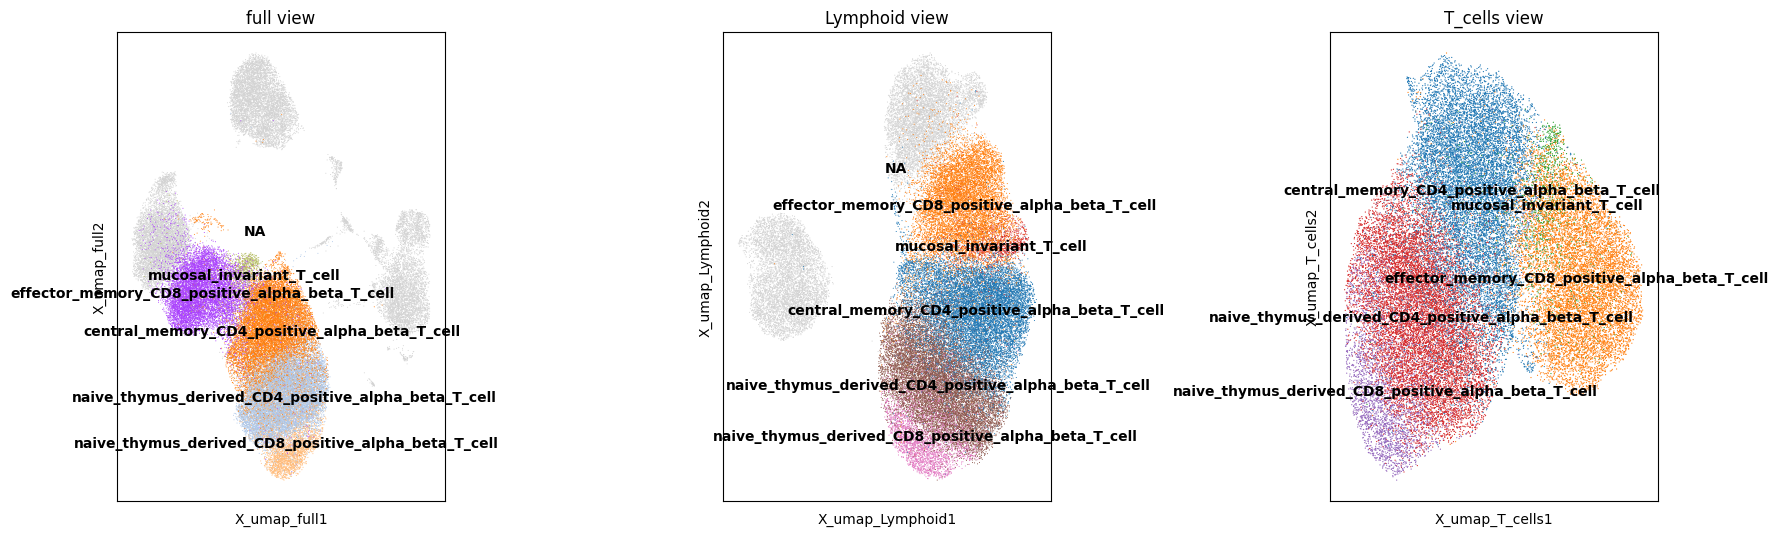

In [47]:
mva.pl.multiview_embedding(mvatlas, view='T_cells', color='cell_type')

### Save models and store file location in mvatlas

In [37]:
# for v,model in model_dict.items():
#     if not os.path.exists('./data/'):
#         os.mkdir('./data/')
#     model_dir = f'./data/scvi_model_{v}'
#     model.save(model_dir, save_anndata=True, overwrite=True)
#     mvatlas.mdata.mod[v].uns['model_dir'] = model_dir

In [48]:
def write_mvatlas(mvatlas, h5mu_file):
    for at in ['views', 'view_hierarchy']:
        mvatlas.mdata['full'].uns[at] = getattr(mvatlas, at)
    getattr(mvatlas, 'view_transition_rule').to_csv(f'{h5mu_file.split(".h5mu")[0]}_transition_rule.csv')
    mvatlas.mdata.var = mvatlas.mdata['full'].var.copy()
    mvatlas.mdata.write_h5mu(h5mu_file)

write_mvatlas(mvatlas, 'data/demo_PBMC_mvatlas.h5mu')

In [13]:
# def read_mvatlas(h5mu_file):
h5mu_file = 'data/demo_PBMC_mvatlas.h5mu'
mdata = mudata.read_h5mu(h5mu_file)
view_transition_rule = pd.read_csv(f'{h5mu_file.split(".h5mu")[0]}_transition_rule.csv', index_col=0)
# mva.tl.MultiViewAtlas(mdata, transition_rule='cell_type')

view_hierarchy = {'full':{
    'Lymphoid':{"T_cells": None},
    'Ery_myeloid':None
}}

mdata.uns['view_hierarchy'] = view_hierarchy.copy()
mvatlas = mva.tl.MultiViewAtlas(mdata, transition_rule='cell_type')
mvatlas.view_transition_rule = view_transition_rule.copy()

for v in ['Lymphoid', 'Ery_myeloid', 'T_cells']:
    model_dir = f'./data/scvi_model_{v}'
    mvatlas.mdata.mod[v].uns['model_dir'] = model_dir

## Map query dataset with existing annotations

Map based on pre-existing annotation: let's say we've uniformed annotations for these datasets, and we want to map based on that. Then we are good to go because the transition rule is based on `cell_type` column. 

In [49]:
for _, row in mvatlas.get_view_pairs().iterrows():
    mvatlas.set_transition_rule(parent_view=row['parent_view'], child_view=row['child_view'], transition_rule='cell_type')

Learn embedding on query cells using scarches

In [50]:
mvatlas_mapped_annotation = mva.tl.load_query(mvatlas, adata_query)
mvatlas_mapped_annotation = mva.tl.split_query(mvatlas_mapped_annotation)

In [51]:
mvatlas_mapped_annotation.mdata['T_cells'].obs['dataset_group'].value_counts()

atlas    39432
query      767
Name: dataset_group, dtype: int64

## Map query dataset by latent dimensions

What if we don't have annotations in our query dataset?

In [53]:
## Remove cell type annotations from query data
adata_query_empty = adata_query.copy()
adata_query_empty.obs.drop('cell_type', axis=1, inplace=True)

In [54]:
# Try mapping query cells
mvatlas_mapped = mva.tl.load_query(mvatlas, adata_query_empty)

ValueError: 
                No mapping possible from full view. Please add info on rules ['cell_type'] to query dataset
                

We need to change our transition rules, to tell the mapping function to use the latent space instead. In this case we have a mapping space for the first level, but not the others.

In [55]:
## Change transition rules to use position in latent space instead of labels
mvatlas.set_transition_rule(parent_view='full', child_view='Ery_myeloid', transition_rule='X_scVI_full')
mvatlas.set_transition_rule(parent_view='full', child_view='Lymphoid', transition_rule='X_scVI_full')
mvatlas.set_transition_rule(parent_view='Lymphoid', child_view='T_cells', transition_rule='X_scVI_Lymphoid')

In [56]:
mvatlas_mapped = mva.tl.load_query(mvatlas, adata_query)

ValueError: 
                No mapping possible from full view. Please add info on rules ['X_scVI_full'] to query dataset
                

In [59]:
mvatlas_mapped = mva.tl.map_query_multiview(mvatlas, adata_query_empty)

INFO     File ./data_full/model.pt already downloaded                                        
INFO     Found 100.0% reference vars in query data.                                          
INFO     File ./data_full/model.pt already downloaded                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=3.7e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=3.7e+03, v_num=1]


INFO     File ./data_Ery_myeloid/model.pt already downloaded                                 
INFO     Found 88.94999999999999% reference vars in query data.                              
INFO     File ./data_Ery_myeloid/model.pt already downloaded                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s, loss=4.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s, loss=4.52e+03, v_num=1]
INFO     File ./data_Lymphoid/model.pt already downloaded                                    
INFO     Found 95.82000000000001% reference vars in query data.                              
INFO     File ./data_Lymphoid/model.pt already downloaded                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s, loss=3.62e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s, loss=3.62e+03, v_num=1]
INFO     File ./data/_T_cells/model.pt already downloaded                                    
INFO     Found 93.67999999999999% reference vars in query data.                              
INFO     File ./data/_T_cells/model.pt already downloaded                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s, loss=3.6e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s, loss=3.6e+03, v_num=1]


In [61]:
mva.tl.knn_umap_multiview(mvatlas_mapped, n_neighbors=20)

Epoch 1/50:   0%|          | 0/50 [37:12<?, ?it/s]


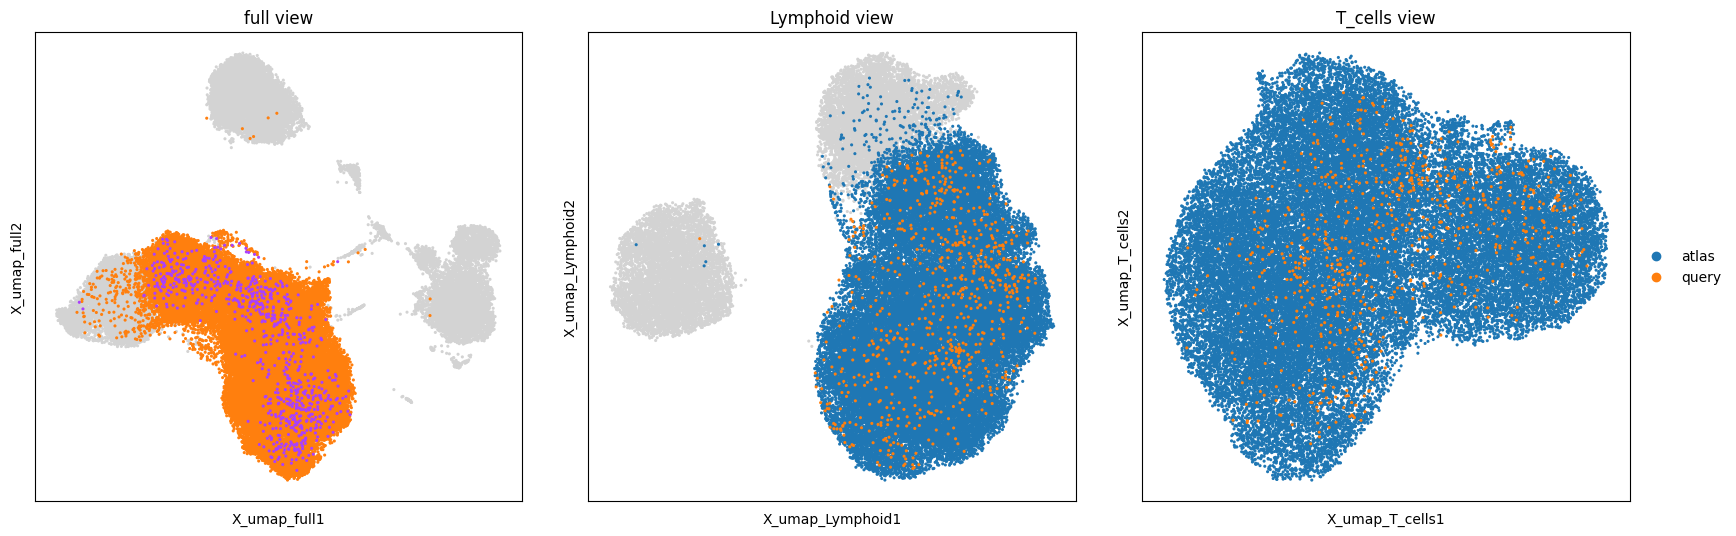

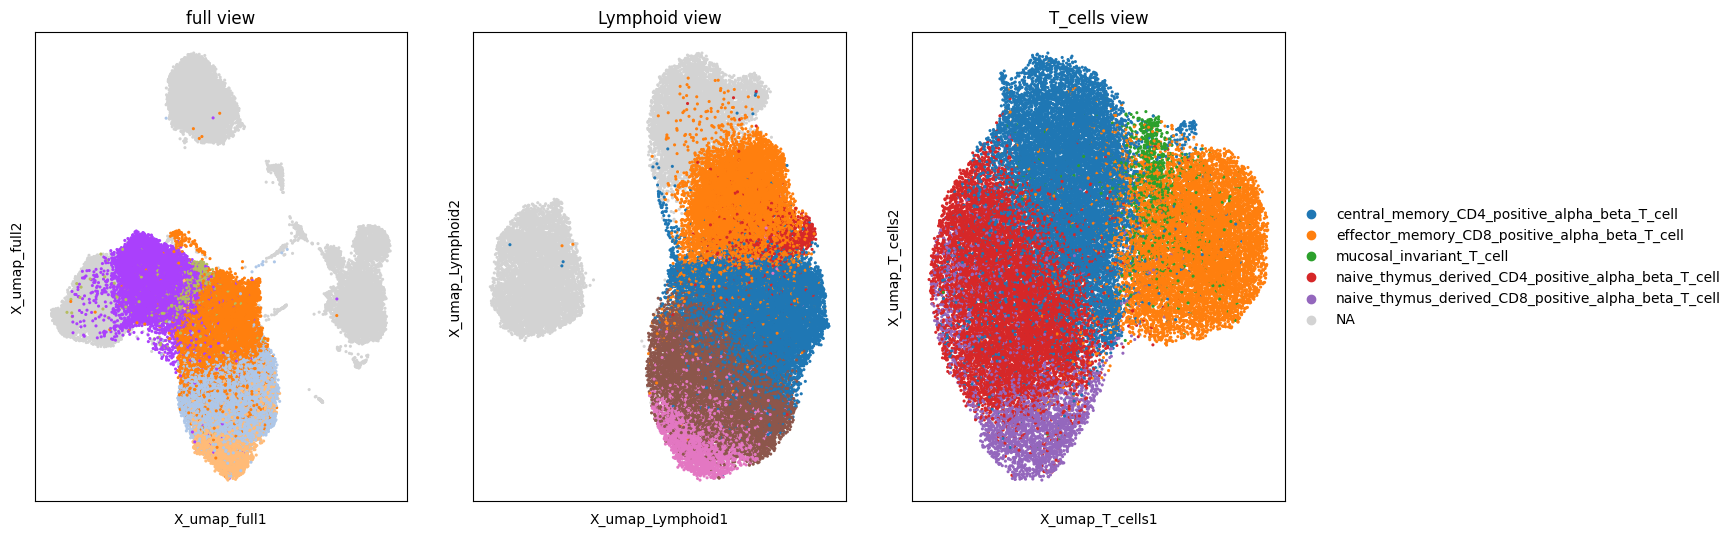

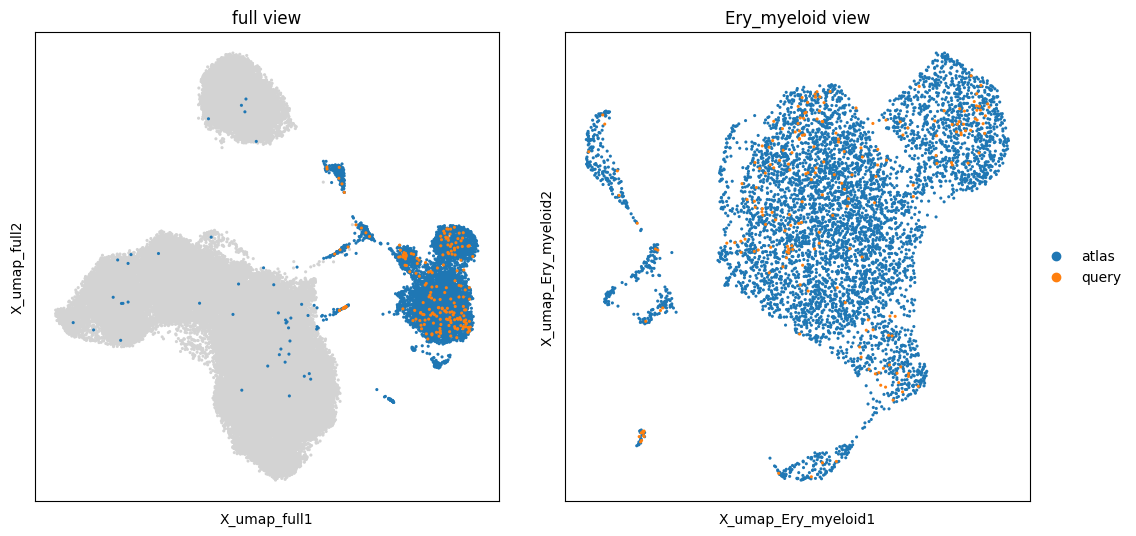

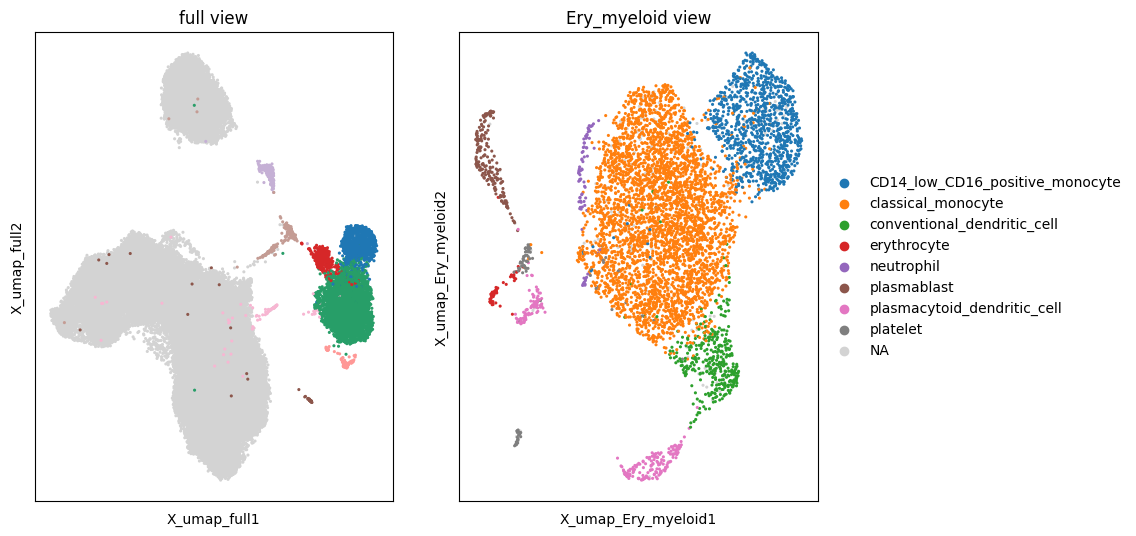

In [66]:
mva.pl.multiview_embedding(mvatlas_mapped, view='T_cells', color='dataset_group', size=20, legend_loc='right margin')
mva.pl.multiview_embedding(mvatlas_mapped, view='T_cells', color='cell_type', size=20, legend_loc='right margin')

mva.pl.multiview_embedding(mvatlas_mapped, view='Ery_myeloid', color='dataset_group', size=20, legend_loc='right margin')
mva.pl.multiview_embedding(mvatlas_mapped, view='Ery_myeloid', color='cell_type', size=20, legend_loc='right margin')

In [67]:
write_mvatlas(mvatlas, 'data/demo_PBMC_mvatlas.with_query.h5mu')

---
---